# Example of pdf de-identification using CleverDoc

![apicom.pro](https://apicom.pro/static/logo-small-borderless.8f68168a2b0e.png)

### Install CleverDoc package

In [ ]:
%pip install -U cleverdoc[inference-gpu]

### Start Spark Session with CleverDoc

For get Trial license please contact to email: [license@apicom.pro](license@apicom.pro)

In [ ]:
license = "your_license_here"

from cleverdoc import start
spark = start(license)
spark

## Define CleverDoc pipeline

In [2]:
from cleverdoc import *
import importlib.resources
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml.pipeline import PipelineModel

In [3]:
binary_to_image = BinaryToImage() \
    .setInputCol("image")

# Define OCR model
image_to_string = ImageToString() \
    .setKeepInput(True)

# Define NER model
# for GPU use Device.GPU.value
ner = Ner() \
    .setOutputCol("ner") \
    .setModel("ApicomPro/deid-bert-onnx-1.2.0")\
    .setNumPartitions(1) \
    .setDevice(Device.CPU.value) \
    .setThreshold(0.0)

image_draw_boxes = ImageDrawBoxes()\
    .setInputCols(["image", "ner"]) \
    .setOutputCol("image_with_boxes") \
    .setFilled(True) \
    .setColor("grey") \
    .setKeepInput(False) \
    .setNumPartitions(32)

image_to_pdf = SingleImageToPdf() \
    .setInputCol("image_with_boxes") \
    .setOutputCol("single_pdf") \

pdf_assembler = PdfAssembler() \
    .setInputCol("single_pdf") \
    .setOutputCol("pdf") \

pipeline = PipelineModel(stages=[binary_to_image,
                                 image_to_string,
                                 ner,
                                 image_draw_boxes,
                                 image_to_pdf,
                                 #pdf_assembler
                                ])

License uid: a6e80c86-204a-11ef-976d-0242ac130004
License expiration date: 2025-06-02 01:59:59


## Load example pdf from resources

In [4]:
pdf_example = importlib.resources.files('cleverdoc').joinpath('resources/pdfs/Positive-Report.pdf').as_posix()

df = spark.read.format("pdf") \
    .option("imageType", "RGB") \
    .option("pagePerPartition", "1") \
    .option("resolution", "200") \
    .load(pdf_example)

# Print total number of pages 
df.count()

23

## Display rendered pages

License uid: a6e80c86-204a-11ef-976d-0242ac130004
License expiration date: 2025-06-02 01:59:59



    Image #0:
    Origin: file:///home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/cleverdoc/resources/pdfs/Positive-Report.pdf
    Resolution: 200 dpi
    Width: 1700 px
    Height: 2200 px


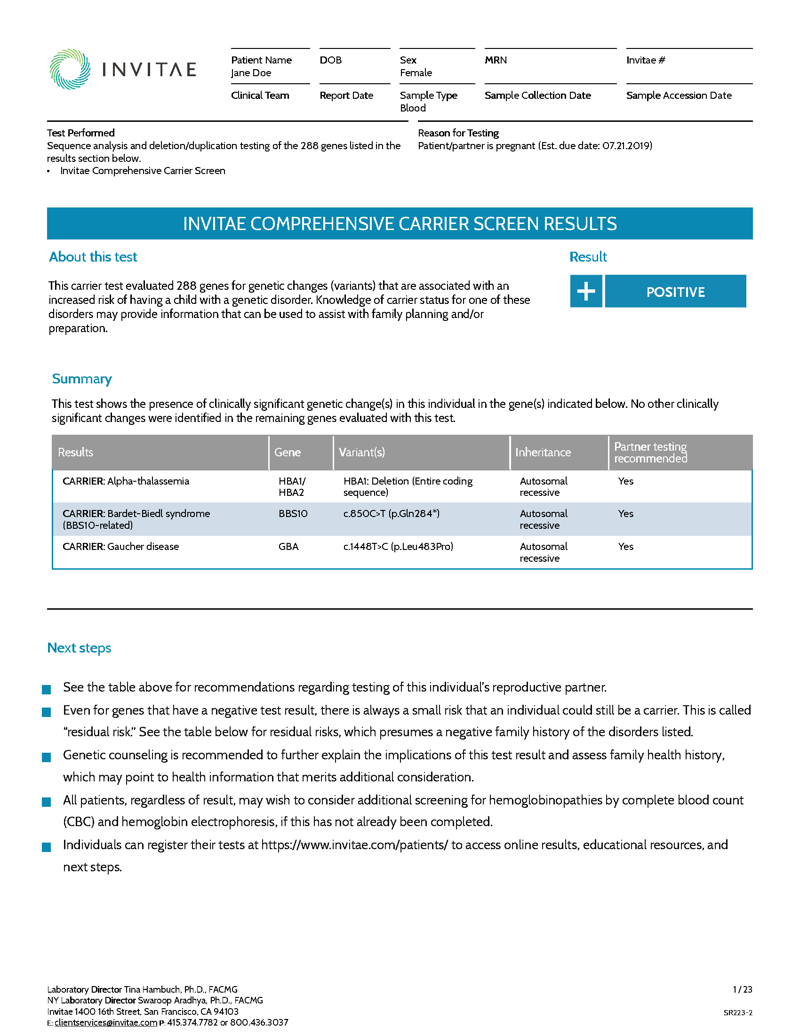


    Image #1:
    Origin: file:///home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/cleverdoc/resources/pdfs/Positive-Report.pdf
    Resolution: 200 dpi
    Width: 1700 px
    Height: 2200 px


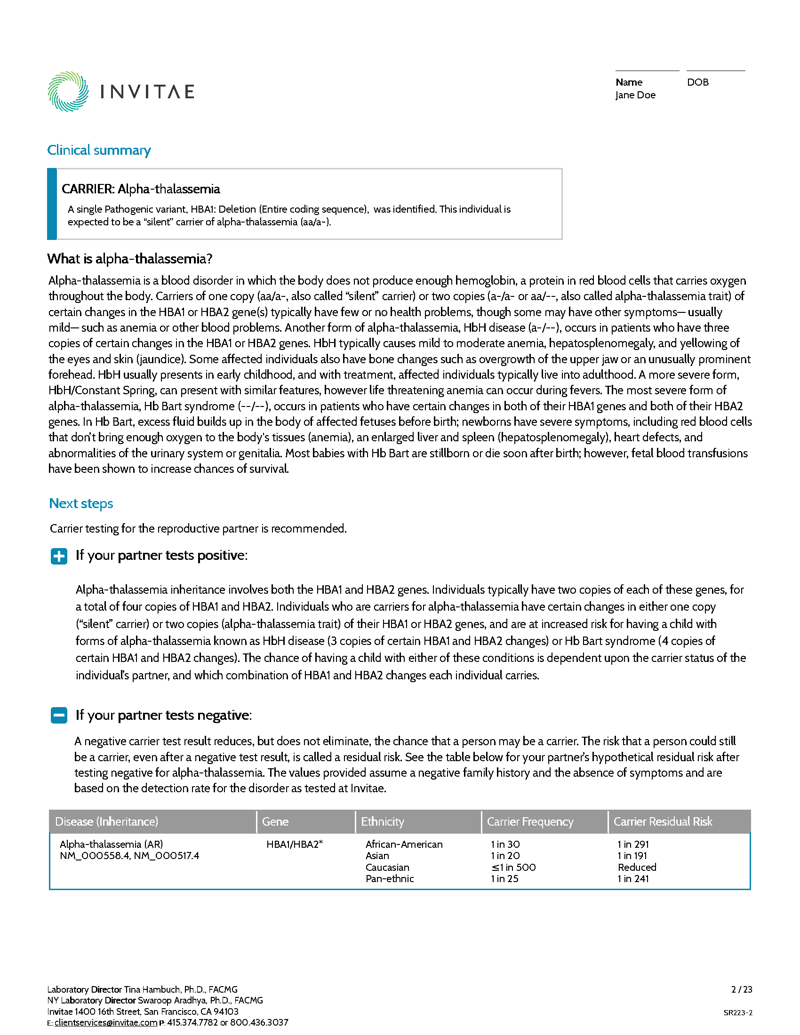

In [5]:
show_images(df, "image", limit=2, width=800)

## Run CleverDoc pipeline and display results

2024-06-10 08:21:20.061147 INFO: Run NER=======================>  (22 + 1) / 23]
/home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/transformers/configuration_utils.py:496: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/transformers/models/auto/configuration_auto.py:1123: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
2024-06-10 08:21:23.575587 INFO: Start processing NER
2024-06-10 08:21:29.578563 INFO: End NER



    Image #0:
    Origin: file:///home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/cleverdoc/resources/pdfs/Positive-Report.pdf
    Resolution: 200 dpi
    Width: 1700 px
    Height: 2200 px


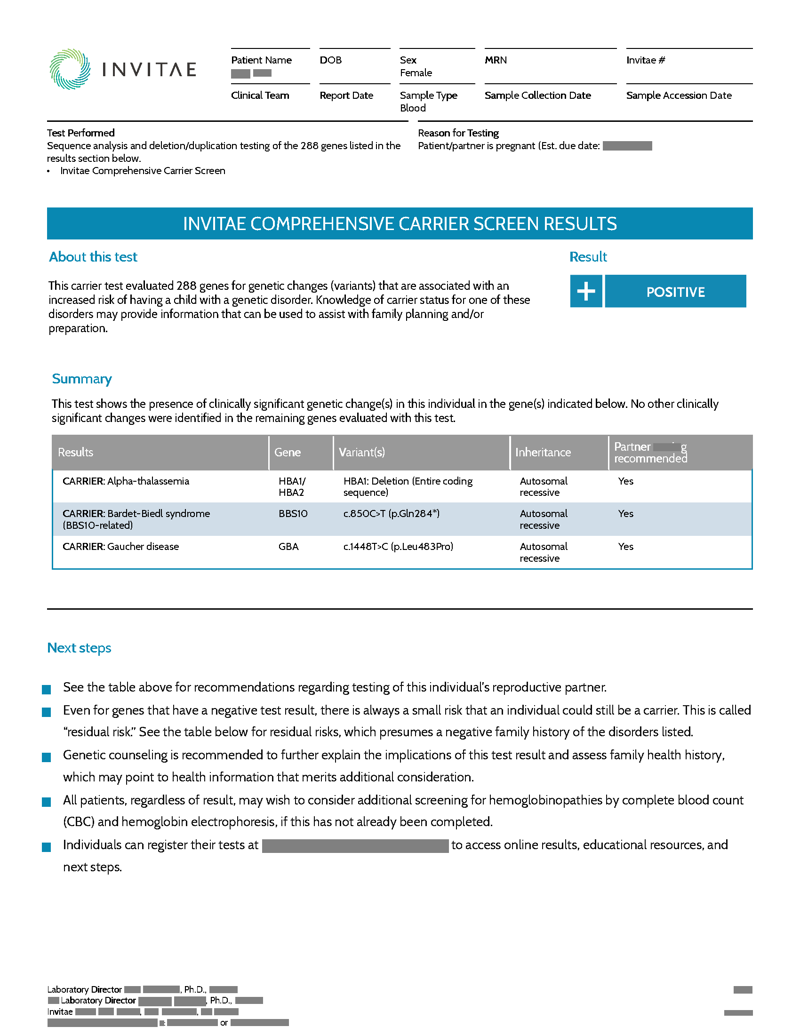


    Image #1:
    Origin: file:///home/nmelnik/jupyterlab/my-python39-env/lib/python3.9/site-packages/cleverdoc/resources/pdfs/Positive-Report.pdf
    Resolution: 200 dpi
    Width: 1700 px
    Height: 2200 px


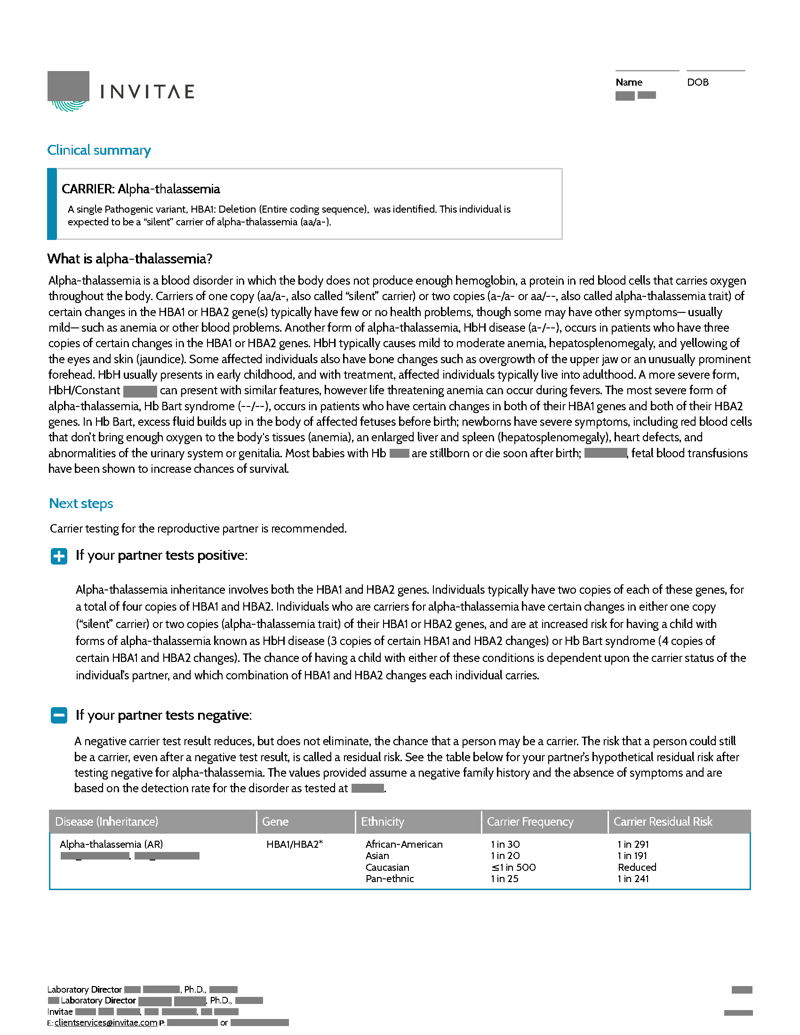

In [6]:
result = pipeline.transform(df).orderBy(f.col("page_number")).cache()
show_images(result, "image_with_boxes", limit=2, width=800)

## Display extracted text for first page

In [7]:
result.select("text.text").collect()[0][0]

'FY Patient Name DOB Sex MRN Invitae # ZANVITAE Jane Doe Female We Clinical Team Report Date Sample Type Sample Collection Date Sample Accession Date Blood Test Performed Reason for Testing Sequence analysis and deletion/duplication testing of the 288 genes listed in the Patient/partner is pregnant (Est. due date: 07.21.2019) results section below. Invitae Comprehensive Carrier Screen About this test Result This carrier test evaluated 288 genes for genetic changes (variants) that are associated with an increased risk of having a child with a genetic disorder. Knowledge of carrier status for one of these Pe] rosrve | disorders may provide information that can be used to assist with family planning and/or preparation. Summary This test shows the presence of clinically significant genetic change(s) in this individual in the gene(s) indicated below. No other clinically significant changes were identified in the remaining genes evaluated with this test Partner testin; Results Gene Variant(s

## Display extracted entities for first page

In [8]:
result.limit(1).select(f.explode("ner").alias("ner")).select("ner.*").show(50)

+------------+------------------+--------------+-----+----+--------------------+---------+
|entity_group|             score|          word|start| end|               boxes|exception|
+------------+------------------+--------------+-----+----+--------------------+---------+
|     PATIENT|0.9943916201591492|          Jane|   47|  51|[{Jane, 96.643783...|         |
|     PATIENT|0.9251964092254639|           Doe|   52|  55|[{Doe, 95.5397567...|         |
|        DATE|0.9990146160125732|            07|  315| 317|[{07.21.2019), 83...|         |
|        DATE| 0.989648163318634|             .|  317| 318|[{07.21.2019), 83...|         |
|        DATE|0.9930201172828674|            21|  318| 320|[{07.21.2019), 83...|         |
|        DATE|0.6045859456062317|          2019|  321| 325|[{07.21.2019), 83...|         |
|       STAFF|0.5240186452865601|        testin|  969| 975|[{testin;, 26.950...|         |
|       STAFF|0.9711795449256897|          Awww| 2119|2123|[{https:/Awww.inv...|         |

## Save de-identified pdf using PdfAssembler and pdfFormat writer

In [9]:
pdf_assembler.transform(result) \
    .withColumn("fileName", f.udf(get_name, StringType())(f.col("pdf.origin"))) \
    .withColumn("pdfFile", f.col("pdf.data")) \
    .write \
    .format("pdfFormat") \
    .option("type", "pdf") \
    .option("field", "pdfFile") \
    .option("nameField", "fileName") \
    .option("extension", "pdf") \
    .option("prefix", "") \
    .mode("append") \
    .save("de-identified_pdfs")

## Check saved pdf

In [10]:
!ls de-identified_pdfs

Positive-Report.pdf  _SUCCESS
